In [1]:
import networkx as nx
import itertools
import numpy as np
import random
import timeit
from matplotlib import pyplot as plt

$$ D = \frac{2 |E|}{|V|(|V| -1)}$$

In [2]:
def weighten(G):
    for (u, v, w) in G.edges(data=True):
        w['weight'] = np.random.uniform()
    return G

In [3]:
def path_to_edge_list(p):
    return [(p[i], p[i+1]) for i in range(len(p)-1)]
    
def all_pairs_shortest_path_subgraph(G):
    edgelist = set()
    apsp = dict(nx.all_pairs_dijkstra_path(G))
    for (i, j) in itertools.combinations(range(G.number_of_nodes()), 2):
        edgelist.update(path_to_edge_list(apsp[i][j]))
    
    return nx.Graph(edgelist)

In [4]:
V = 1000
D = 0.01
E = round(D*V*(V-1)/2)

assert round(E / V) == 5

G = nx.barabasi_albert_graph(V, round(E/V))
G = weighten(G)
print(G.number_of_edges())

In [5]:
N = 1000

In [6]:
start = timeit.default_timer()
Distances = []

for _ in range(10):
    distances = []
    g = nx.laplacian_spectrum(G)
    distances.append(np.linalg.norm(g-g))
    H = G.copy()
    for _ in range(N):
        H.remove_edge(*random.choice(list(H.edges)))
        h = nx.laplacian_spectrum(H)
        distances.append(np.linalg.norm(g-h))
    Distances.append(distances)
    print(f'Time: {timeit.default_timer() - start:.0f} s')

Time: 169 s
Time: 343 s
Time: 520 s
Time: 687 s
Time: 857 s
Time: 1025 s
Time: 1190 s
Time: 1370 s
Time: 1549 s
Time: 1760 s


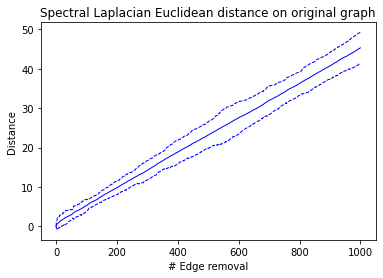

In [10]:
x = np.array(range(N+1))
m = np.mean(Distances, axis=0)
s = np.std(Distances, axis=0)
plt.plot(x, m, color='b', linewidth=1, label='mean')
plt.plot(x, m + 3*s, color='b', linewidth=1, linestyle='--', label='mean + 3 std')
plt.plot(x, m - 3*s, color='b', linewidth=1, linestyle='--', label='mean - 3 std')
plt.title('Spectral Laplacian Euclidean distance on original graph')
plt.xlabel('# Edge removal')
plt.ylabel('Distance')
plt.savefig('Spectral Laplacian Euclidean distance on original graph.png', dpi=200)

In [9]:
start = timeit.default_timer()
G_backbone = all_pairs_shortest_path_subgraph(G)
assert G.number_of_nodes() == G_backbone.number_of_nodes()
print(f'Time: {timeit.default_timer() - start:.0f} s')

Time: 14 s
